In [1]:
import torch
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from neuralforecast.models import TFT

from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM, RMSE

from typing import Optional, Union, Tuple

import sranodec as anom
import pickle as pkl
import joblib

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
import numpy as np
import pandas as pd
import pytorch_forecasting

import optuna
from optuna.trial import TrialState
import joblib
from optuna.study import StudyDirection

from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting import Baseline
from pytorch_forecasting import TemporalFusionTransformer
#from pytorch_forecasting.metrics.quantile import QuantileLoss
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss

from sklearn.metrics import mean_squared_error
from math import sqrt


import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

from pytorch_lightning.loggers import TensorBoardLogger

import torch

torch.set_float32_matmul_precision('high')

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.impute import SimpleImputer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
def index_agreement(s, o):
    """
        index of agreement
        Willmott (1981, 1982)
        input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 - (np.sum((o - s) ** 2)) / (
        np.sum((np.abs(s - np.mean(o)) + np.abs(o - np.mean(o))) ** 2)
    )
    return ia

In [4]:
def smape(s, o) -> float:
    """
        Symmetric Mean Absolute
        Percentage Error 
        input:
        s: simulated
        o: observed
    output:
        _smape: smape
    """
    if not all([isinstance(o, np.ndarray), 
                isinstance(s, np.ndarray)]):
        s, o = np.array(s), np.array(o)
    _smape = round(
        np.mean(
            np.abs(s - o) / 
            ((np.abs(s) + np.abs(o))/2)
        )*100, 2
    ) 
    return _smape 

In [5]:
def rmse(s,o) -> float:
    _rmse = sqrt(mean_squared_error(o, s))
    return _rmse

In [6]:
train_interval = pd.date_range(start='2021-04-01 00:00:00+00:00', 
                               end='2021-08-31 23:50:00+00:00', 
                               freq='10min', tz='UTC')

#train_interval = pd.date_range(start='2020-01-01 00:00:00+00:00', 
#                               end='2021-08-31 23:50:00+00:00', 
#                               freq='10min', tz='UTC')

test_interval = pd.date_range(start='2021-09-01 00:00:00+00:00', 
                               end='2021-12-31 23:50:00+00:00', 
                               freq='10min', tz='UTC')

In [7]:
def filter_df(df_inputed,
              shift=0,
              freq='min',
              reset_index=True,
              find_method='nearest',
              drop_list=['available_since'],
              ft_list=['ssh'],
              name=None,
              interval=train_interval):
    
    df_src = df_inputed.drop(drop_list, axis=1).copy()
    
    # convert datetime column to datetime format
    df_src['datetime'] = pd.to_datetime(df_src['datetime'])
    
    # set index
    df_src = df_src.set_index(['datetime'])
    
    # apply shift
    if shift > 0: df_src = df_src.shift(shift, freq=freq)
          
    df_tgt = df_src.reindex(interval).copy()
    
    for ft in ft_list:
        nan_list = df_tgt[df_tgt[ft].isna()].index
        for dt in nan_list:            
            nearest_index = df_src.index.get_loc(dt, method=find_method)
            target_ft =  df_src.loc[df_src.index == df_src.index[nearest_index],ft]
            df_tgt.loc[df_tgt.index == dt,ft] = target_ft.values[0]
 
    df_tgt['datetime'] = df_tgt.index
    if reset_index:
        df_tgt = df_tgt.reset_index(drop=True).copy()
    
    print(f'{name} Done!')
        
    return df_tgt

## Train datasets

In [8]:
#######################  cur  ############################

#### datasets current projection praticagem ####
src_train_cur_msrd_praticagem = pd.read_csv('../data/data_santos_port/data_filtered/train/current_projection/current_projection_praticagem/current_projection_praticagem.csv')
df_train_cur_msrd_praticagem = filter_df(src_train_cur_msrd_praticagem,
                                        ft_list=["velocity_projection"],
                                        interval=train_interval,
                                        name='train_cur_msrd_praticagem')

#######################  ssh  ############################

#### datasets astronomical tide simulated praticagem ####
src_train_ssh_msrd_praticagem = pd.read_csv('../data/data_santos_port/data_filtered/train/ssh_measured/ssh_measured_praticagem/ssh_measured_praticagem.csv')
df_train_ssh_msrd_praticagem = filter_df(src_train_ssh_msrd_praticagem,
                                        ft_list=['ssh'],
                                        interval=train_interval,
                                        name='train_ssh_msrd_praticagem')

#######################  AT  ############################

#### datasets astronomical tide simulated tiplam ####
src_train_at_simu_praticagem = pd.read_csv('../data/data_santos_port/data_filtered/train/astronomical_tide/astronomical_tide_praticagem/astronomical_tide_praticagem.csv')
df_train_at_simu_praticagem = filter_df(src_train_at_simu_praticagem, 
                                       ft_list=['astronomical_tide'],
                                       interval=train_interval,
                                       name='train_at_simu_praticagem')

train_cur_msrd_praticagem Done!
train_ssh_msrd_praticagem Done!
train_at_simu_praticagem Done!


## Test datasets

In [9]:
#######################  cur  ############################

#### datasets current projection praticagem ####
src_test_cur_msrd_praticagem = pd.read_csv('../data/data_santos_port/data_filtered/test/current_projection/current_projection_praticagem/current_projection_praticagem.csv')
df_test_cur_msrd_praticagem = filter_df(src_test_cur_msrd_praticagem,
                                        ft_list=["velocity_projection"],
                                        interval=test_interval,
                                        name='test_cur_msrd_praticagem')

#######################  ssh  ############################

#### datasets astronomical tide simulated praticagem ####
src_test_ssh_msrd_praticagem = pd.read_csv('../data/data_santos_port/data_filtered/test/ssh_measured/ssh_measured_praticagem/ssh_measured_praticagem.csv')
df_test_ssh_msrd_praticagem = filter_df(src_test_ssh_msrd_praticagem,
                                        ft_list=['ssh'],
                                        interval=test_interval,
                                        name='test_ssh_msrd_praticagem')

#######################  AT  ############################

#### datasets astronomical tide simulated tiplam ####
src_test_at_simu_praticagem = pd.read_csv('../data/data_santos_port/data_filtered/test/astronomical_tide/astronomical_tide_praticagem/astronomical_tide_praticagem.csv')
df_test_at_simu_praticagem = filter_df(src_test_at_simu_praticagem, 
                                       ft_list=['astronomical_tide'],
                                       interval=test_interval,
                                       name='test_at_simu_praticagem')

test_cur_msrd_praticagem Done!
test_ssh_msrd_praticagem Done!
test_at_simu_praticagem Done!


In [10]:
df_train_dict = {
    "praticagem":{
        'msrd_current':{
            'vars':['velocity_projection'],
            'source': df_train_cur_msrd_praticagem
        },
        'msrd_ssh':{
            'vars':['ssh'],
            'source': df_train_ssh_msrd_praticagem
        },
        'simu_at':{
            'vars':['astronomical_tide'],
            'source': df_train_at_simu_praticagem
        }
    }
}

In [11]:
df_test_dict = {
    "praticagem":{
        'msrd_current':{
            'vars':['velocity_projection'],
            'source': df_test_cur_msrd_praticagem
        },
        'msrd_ssh':{
            'vars':['ssh'],
            'source': df_test_ssh_msrd_praticagem
        },
        'simu_at':{
            'vars':['astronomical_tide'],
            'source': df_test_at_simu_praticagem
        }
    }
}

## Parsing dataframes

In [12]:
from neuralforecast.auto import NHITS
from neuralforecast.core import NeuralForecast

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

horizon = 144 # day-ahead daily forecast
window_size = horizon * 7 # 7 days
unique_id = 'location'
earliest_time = train_interval.min()

In [13]:
def data_gen(df_dict=df_train_dict,
             interval=train_interval,
             earliest_time=earliest_time):
    df_santos = pd.DataFrame()
    locations = df_dict.keys()
    
    spec = anom.Silency(horizon, horizon, window_size)
    
    for local in locations:
        df_local = pd.DataFrame(index=interval)
        df_local['location'] = local
        features = df_dict[local].keys()
        for ft in features:
            env_vars = df_dict[local][ft]['vars']
            for var in env_vars:
                signal = df_dict[local][ft]['source'][var].values
                score = spec.generate_anomaly_score(signal, type="abs")
                index_changes = np.where(score > np.percentile(score, 99))[0]
                
                df_local[f'{ft}_{var}'] = signal
                df_local[f'{ft}_{var}_residual'] = score
                df_local[f'{ft}_{var}_is_anom'] = 0
                df_local.loc[df_local.index.isin(interval[index_changes]),f'{ft}_{var}_is_anom'] = 1
                
        df_santos = pd.concat([df_santos, df_local])

    #earliest_time = df_santos.index.min()

    date = df_santos.index

    df_santos['10min_from_start'] = ((date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24)*6
    df_santos['10min_from_start'] = df_santos['10min_from_start'].astype('int')
    df_santos['days_from_start'] = (date - earliest_time).days
    df_santos['date'] = pd.to_datetime(date)
    df_santos['hour'] = date.hour
    df_santos['day'] = date.day
    df_santos['day_of_week'] = date.dayofweek
    df_santos['month'] = date.month
    df_santos['year'] = date.year
        
    return df_santos.reset_index(drop=True)

In [14]:
df_train = data_gen(df_dict=df_train_dict)
df_test = data_gen(df_dict=df_test_dict, interval=test_interval)

In [15]:
shift=0
df_test_cropped = pd.DataFrame()
for loc in df_test_dict.keys():
    local_df_test = df_test[df_test[unique_id] == loc].reset_index(drop=True)[0+shift:horizon+shift].reset_index(drop=True)
    df_test_cropped = pd.concat([df_test_cropped,local_df_test])
df_test_cropped = df_test_cropped.reset_index(drop=True)

## Temporal Fusion Trasformer

In [16]:
time_df = df_train

earliest_time = time_df.index.min()
max_prediction_length = horizon
max_encoder_length = window_size
training_cutoff = time_df.index.max() - max_prediction_length

training = TimeSeriesDataSet(
    time_df[lambda x: x["10min_from_start"] <= training_cutoff],
    time_idx="10min_from_start",
    target='msrd_current_velocity_projection',
    group_ids=['location'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['location'],

    time_varying_known_reals=["10min_from_start",
                              "day",
                              "day_of_week",
                              "year", 
                              "month",
                              'hour',
                              'simu_at_astronomical_tide',
                              'simu_at_astronomical_tide_residual',
                              'simu_at_astronomical_tide_is_anom'
                             ],

    time_varying_unknown_reals=['msrd_current_velocity_projection',
                                'msrd_current_velocity_projection_residual',
                                'msrd_ssh_ssh',
                                'msrd_ssh_ssh_residual',
                                'msrd_current_velocity_projection_is_anom',
                                'msrd_ssh_ssh_is_anom'
                               ],

    target_normalizer=GroupNormalizer(groups=['location']),

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True,
                                            stop_randomization=True)

# create dataloaders for  our model
batch_size = 32
# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, 
                                          num_workers=32)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, 
                                          num_workers=32)

## Find optimal learning rate

In [17]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 34.2k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

suggested learning rate: 0.048977881936844644


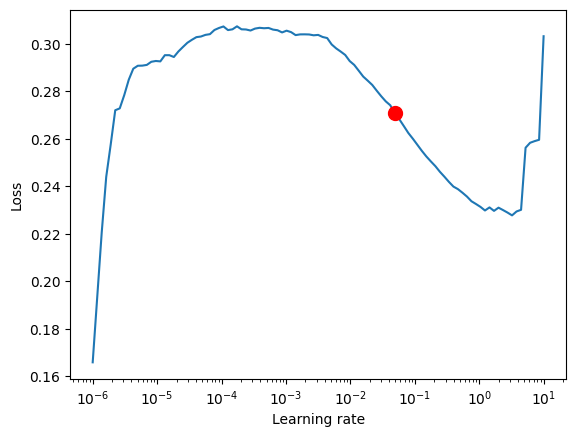

In [18]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
#fig = res.plot(show=True, suggest=True)
#fig.show()

## Train model

In [19]:
early_stop_callback = EarlyStopping(monitor="val_loss", 
                                    min_delta=1e-5, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.223133,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    hidden_size=207,
    attention_head_size=3,
    dropout=0.118175,
    hidden_continuous_size=208,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 7265.7k


In [20]:
#trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [21]:
#!zip -r models/praticagem_without_sranodec_freq10min_08042023.zip lightning_logs/lightning_logs/version_11/*

In [41]:
best_model_path='lightning_logs/lightning_logs/version_13/checkpoints/epoch=8-step=24660.ckpt'
#best_model_path = 'models/praticagem_with_sranodec_freq10min_08042023/lightning_logs/version_10/checkpoints/epoch=5-step=16440.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

## Hyperparameter tuning

In [37]:
with open('test_study_11042023.pkl', 'rb') as f:
    study_tft = pickle.load(f)

In [ ]:
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=50,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    study = study3
)

In [38]:
# show best hyperparameters
print(study_tft.best_trial.params)

{'gradient_clip_val': 0.18163353941989832, 'hidden_size': 83, 'dropout': 0.2504983029367468, 'hidden_continuous_size': 32, 'attention_head_size': 3, 'learning_rate': 0.019742091102042}


In [40]:
study_tft.best_trial.params['gradient_clip_val']

0.18163353941989832

In [35]:
# save study results - also we can resume tuning at a later point in time
with open("test_study_11042023.pkl", "wb") as fout:
    pickle.dump(study, fout)

In [42]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

# 0.46909692883491516
# tensor([4.2036e-02, 1.2868e-06, 6.5122e-02, 1.3133e+00, 8.0899e-02, 1.3133e+00])

0.13533154129981995
tensor([0.1353])


In [43]:
#Take a look at what the raw_ons variable contains

raw_predictions, x = best_tft.predict(val_dataloader,
                                      mode="raw", 
                                      return_x=True)
print(raw_predictions._fields)
# ('prediction', 
# 'encoder_attention', 
# 'decoder_attention', 
# 'static_variables', 
# 'encoder_variables', 
# 'decoder_variables', 
# 'decoder_lengths', 
# 'encoder_lengths')

print('\n')
print(raw_predictions['prediction'].shape)
#torch.Size([3, 24, 7])

# We get predictions of 5 time-series for 24 days.
# For each day we get 7 predictions - these are the 7 quantiles:
#[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# We are mostly interested in the 4th quantile which represents, let's say, the 'median loss'
# fyi, although docs use the term quantiles, the most accurate term are percentiles

('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([1, 144, 7])


In [44]:
index_agreement(np.array(raw_predictions['prediction'][0,:,4]),
                np.array(x['decoder_target'][0,:]))

0.7838938236236572

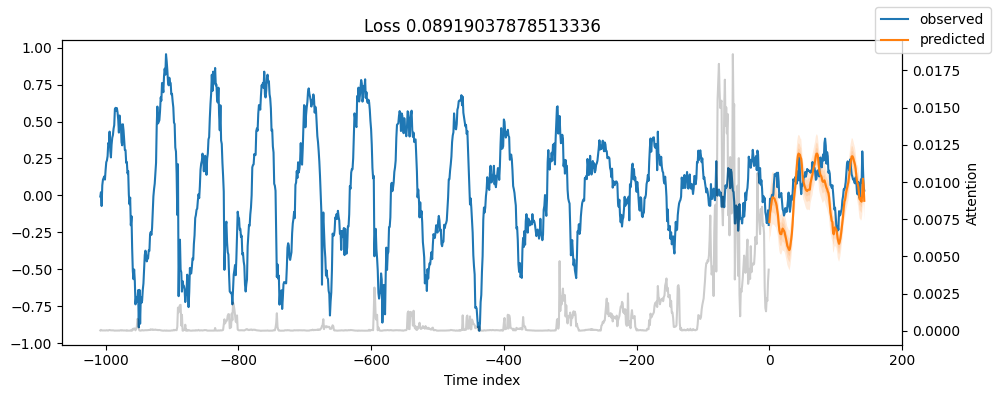

In [ ]:
for idx in range(1):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(x, raw_predictions,
                             idx=idx, add_loss_to_title=True, ax=ax)

In [46]:
#fig, ax = plt.subplots(figsize=(10, 5))

raw_prediction, x = best_tft.predict(val_dataloader,mode="raw",return_x=True)
#best_tft.plot_prediction(x, raw_prediction, idx=0, ax=ax)
#print(index_agreement(np.array(raw_prediction['prediction'][0,:,4]), np.array(x['decoder_target'][0,:])))

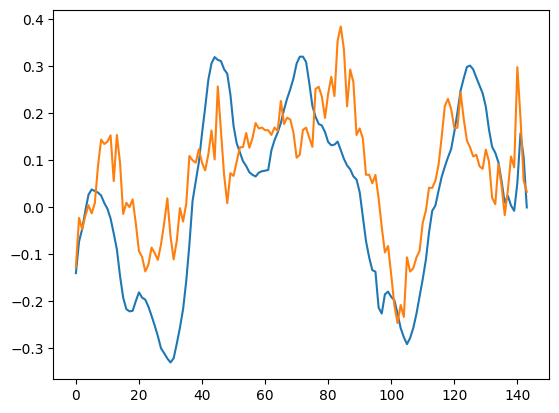

0.7838938236236572


In [47]:
plt.plot(np.array(raw_prediction['prediction'][0,:,4]))
plt.plot(np.array(x['decoder_target'][0,:]))
plt.show()
print(index_agreement(np.array(raw_prediction['prediction'][0,:,4]),np.array(x['decoder_target'][0,:])))

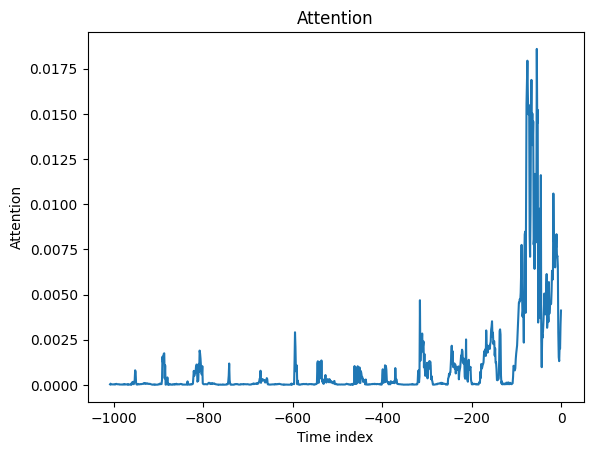

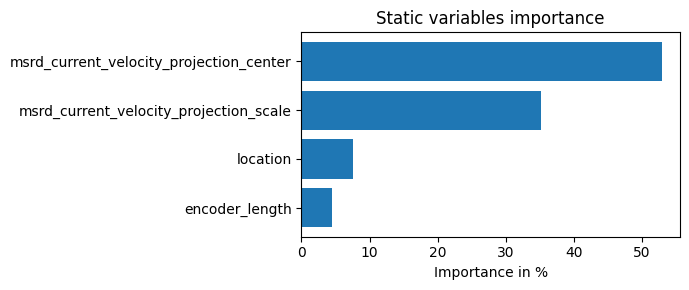

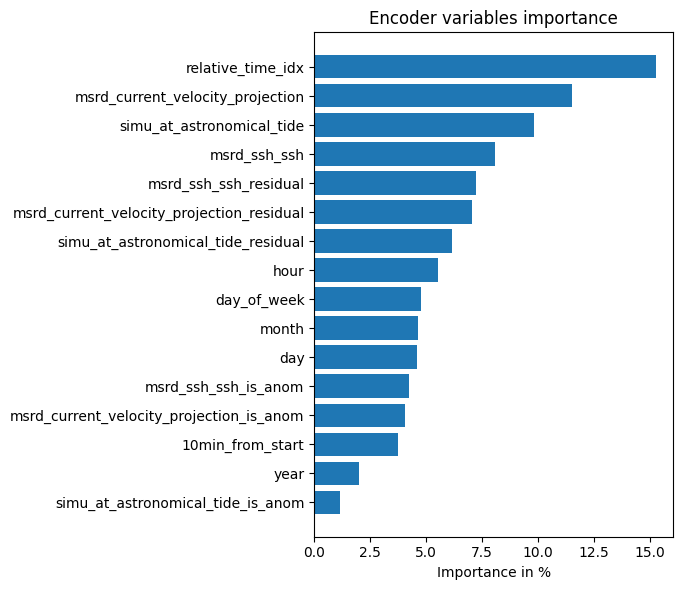

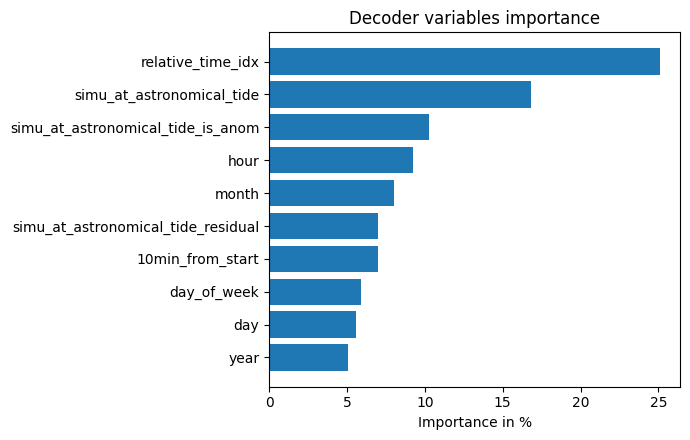

In [48]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)
plt.show()

## future values

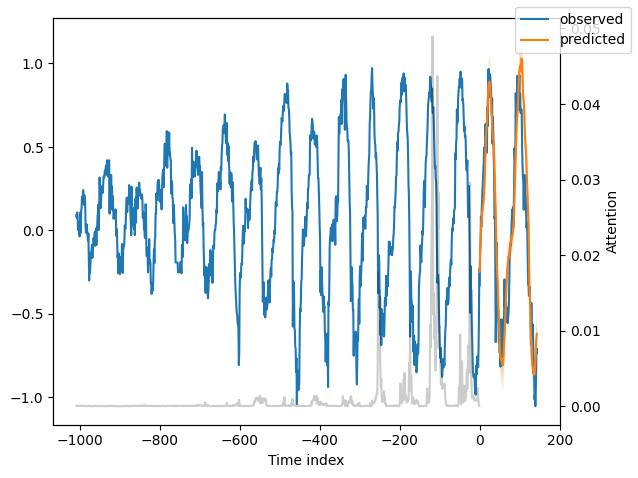

In [49]:
new_raw_predictions, new_x = best_tft.predict(df_test[:1152].reset_index(drop=True), mode="raw", return_x=True)

best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=True)
plt.show()

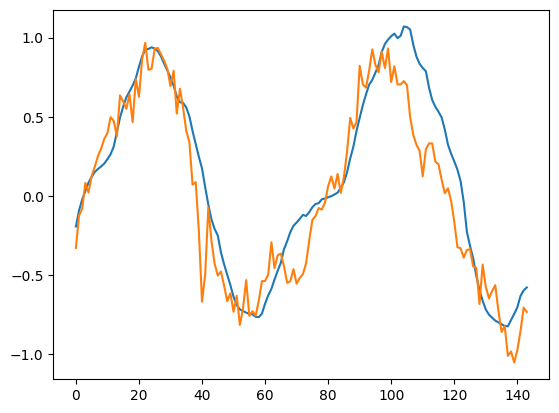

0.956873893737793


In [50]:
plt.plot(np.array(new_raw_predictions['prediction'][0,:,4]))
plt.plot(np.array(new_x['decoder_target'][0,:]))
plt.show()
print(index_agreement(np.array(new_raw_predictions['prediction'][0,:,4]),np.array(new_x['decoder_target'][0,:])))

In [51]:
list_ioa_from_test = []
list_smape_from_test = []
list_rmse_from_test = []

for i in tqdm(range(0,df_test.shape[0]-(max_encoder_length)+1,max_prediction_length)):
    #print(f"{i}:{max_encoder_length+i}")
    new_raw_predictions, new_x = best_tft.predict(df_test[i:max_encoder_length+i].reset_index(drop=True), mode="raw", return_x=True)
    list_ioa_from_test.append(index_agreement(np.array(new_raw_predictions['prediction'][0,:,4]),np.array(new_x['decoder_target'][0,:])))
    list_smape_from_test.append(smape(np.array(new_raw_predictions['prediction'][0,:,4]),np.array(new_x['decoder_target'][0,:])))
    list_rmse_from_test.append(rmse(np.array(new_raw_predictions['prediction'][0,:,4]),np.array(new_x['decoder_target'][0,:])))    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:21<00:00,  5.49it/s]


In [ ]:
#list_ioa_from_test = []
#for i in tqdm(range(0,df_test.shape[0]-(max_encoder_length)+1)):
    #print(f"{i}:{max_encoder_length+i}")
    #new_raw_predictions, new_x = best_tft.predict(df_test[i:max_encoder_length+i].reset_index(drop=True), mode="raw", return_x=True)
    #list_ioa_from_test.append(index_agreement(np.array(new_raw_predictions['prediction'][0,:,4]),np.array(new_x['decoder_target'][0,:])))

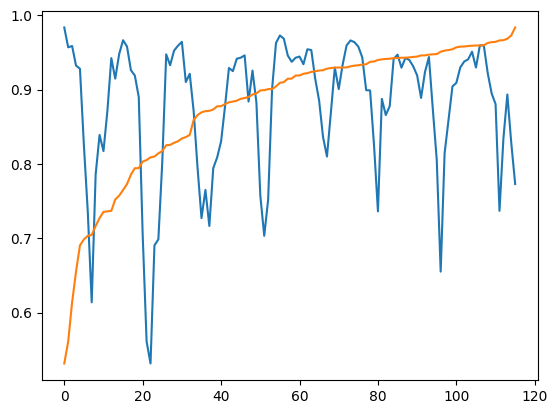

avg IoA:    0.8779365587337263
median IoA: 0.9146713092923164
std IoA:    0.09139931206149166
-------------------------------
avg SMAPE:    78.99077586206896
median SMAPE: 75.22
std RMSE   : 0.05668816473574994
-------------------------------
avg RMSE:    0.21538350216610738
median RMSE: 0.20698536219322525
std RMSE   : 0.05668816473574994


In [56]:
#plt.plot(np.where(np.array(list_ioa_from_test) > np.percentile(np.array(list_ioa_from_test), 99))[0])
plt.plot(list_ioa_from_test)
plt.plot(np.sort(list_ioa_from_test))
#plt.ylim(0,1)
plt.show()

print(f'avg IoA:    {np.mean(list_ioa_from_test)}')
print(f'median IoA: {np.median(list_ioa_from_test)}')
print(f'std IoA:    {np.std(list_ioa_from_test)}')
print(f'-------------------------------\navg SMAPE:    {np.mean(list_smape_from_test)}')
print(f'median SMAPE: {np.median(list_smape_from_test)}')
print(f'std RMSE   : {np.std(list_rmse_from_test)}')
print(f'-------------------------------\navg RMSE:    {np.mean(list_rmse_from_test)}')
print(f'median RMSE: {np.median(list_rmse_from_test)}')
print(f'std RMSE   : {np.std(list_rmse_from_test)}')

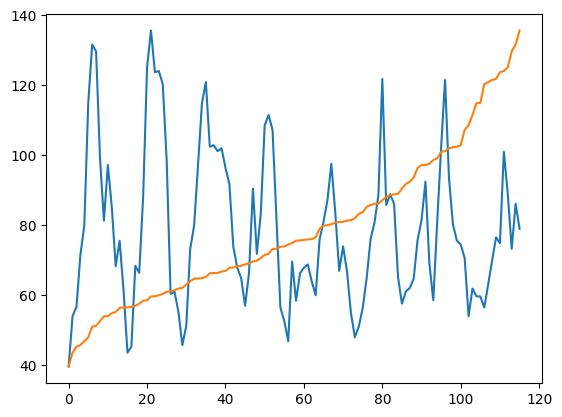

avg IoA:    0.8779365587337263
median IoA: 0.9146713092923164
std IoA:    0.09139931206149166
-------------------------------
avg SMAPE:    78.99077586206896
median SMAPE: 75.22
std SMAPE   : 21.89595767097371
-------------------------------
avg RMSE:    0.21538350216610738
median RMSE: 0.20698536219322525
std RMSE   : 0.05668816473574994


In [55]:
#plt.plot(np.where(np.array(list_ioa_from_test) > np.percentile(np.array(list_ioa_from_test), 99))[0])
plt.plot(list_smape_from_test)
plt.plot(np.sort(list_smape_from_test))
#plt.ylim(0,1)
plt.show()

print(f'avg IoA:    {np.mean(list_ioa_from_test)}')
print(f'median IoA: {np.median(list_ioa_from_test)}')
print(f'std IoA:    {np.std(list_ioa_from_test)}')
print(f'-------------------------------\navg SMAPE:    {np.mean(list_smape_from_test)}')
print(f'median SMAPE: {np.median(list_smape_from_test)}')
print(f'std SMAPE   : {np.std(list_smape_from_test)}')
print(f'-------------------------------\navg RMSE:    {np.mean(list_rmse_from_test)}')
print(f'median RMSE: {np.median(list_rmse_from_test)}')
print(f'std RMSE   : {np.std(list_rmse_from_test)}')

In [ ]:
#Analysis on the training set
predictions, x = best_tft.predict(train_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)
plt.show()